In [6]:
import os
import numpy as np
import pandas as pd
from pandas import concat
import readcsv1
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, ConvLSTM2D, GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot 
from sklearn.metrics import mean_squared_error


USE_all_series =True

if USE_all_series:
    ts = readcsv1.get_data(start='2000-01-01', end='2020-12-31', method='ffill',
     init='bfill', file='file_names.txt', verbose=True)

    
else:
    file_USDEUR = 'Data/USDEUR.csv'
    file_USICSAM = 'Data/USICSAM.csv'
    file_EZ_CI = 'Data/Euro Area Consumer Confidence Index.csv'
    file_german9year = 'Bond-Germany9-yearNoteYield(IGDEU9D).csv'

    time_series_USICSAM = pd.read_csv(file_USICSAM, sep=',', header=2, index_col=0, parse_dates=['Date'])
    time_series_USDEUR = pd.read_csv(file_USDEUR, sep=',', header=2, index_col=0, parse_dates=['Date'])
    time_series_EZ_CI = pd.read_csv(file_EZ_CI, sep=',', header=2, index_col=0, parse_dates=['Date'])

    #we have to first pad missing values and then select dates otherwise dimensions don't match due to low frequency
    time_series_USICSAM = time_series_USICSAM['Close'].resample('D').pad()['2001-01-01':'2020-12-31']  
    time_series_USDEUR = time_series_USDEUR['Close'].resample('D').pad()['2001-01-01':'2020-12-31']
    time_series_EZ_CI = time_series_EZ_CI['Close'].resample('D').pad()['2001-01-01':'2020-12-31']


    print(type(time_series_EZ_CI))
    print('Unemployment claims: \n', time_series_USICSAM)
    print('\n Exchange rate: \n', time_series_USDEUR)
    print('\n Eurozone Consumer Index: \n', time_series_EZ_CI)
    
    #concatenate values (i.e. w/o date) of series into a single array
    print(np.shape(time_series_USICSAM.values))
    ts = np.transpose(np.vstack((time_series_USDEUR.values, time_series_USICSAM.values, time_series_EZ_CI.values )))
    print(np.shape(ts))






0 Data/000-EuroPerDollar(USDEUR).csv Close
1 Data/000-EuroPerDollar(USDEUR).csv Open
2 Data/000-EuroPerDollar(USDEUR).csv High
3 Data/000-EuroPerDollar(USDEUR).csv Low
4 Data/Bond-Germany2-yearNoteYield(IGDEU2D).csv Close
5 Data/Bond-Germany9-yearNoteYield(IGDEU9D).csv Close
6 Data/Bond-MoodyBAA(MOCBAAD).csv Close
7 Data/Bond-US10-yearBondYield(IGUSA10D).csv Close
8 Data/Bond-US2-yearNoteYield(IGUSA2D).csv Close
9 Data/Commod-GoldPrice(__XAU_D).csv Close
10 Data/Commod-GoldPrice(__XAU_D).csv Open
11 Data/Commod-GoldPrice(__XAU_D).csv High
12 Data/Commod-GoldPrice(__XAU_D).csv Low
13 Data/Commod-OilPrice(__WTC_D).csv Close
14 Data/Commod-OilPrice(__WTC_D).csv Open
15 Data/Commod-OilPrice(__WTC_D).csv High
16 Data/Commod-OilPrice(__WTC_D).csv Low
17 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv Close
18 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv Open
19 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv High
20 Data/Commod-ReutersCRBIndex(_TRCCRBD).csv Low
21 Data/Commod-ReutersCRBIndustrialRaw(CMCRBI

number of time steps used is 7671 , and the number of time-series used is 7


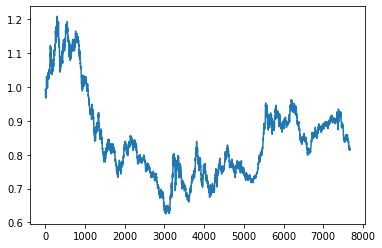

In [7]:
## indicators to use when training
keeplist = [0, 1, 5, 15, 16, 25, 27]
ts = ts[:, keeplist]
no_steps, no_series = ts.shape
print('number of time steps used is %d , and the number of time-series used is %d' %(no_steps, no_series)    )

    
## plot exchange rate
pyplot.plot(ts[:,0])
pyplot.show()

In [8]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = [],[]
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


def delete_multiple_elements(list_object, indices):
    #indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)
            
            

no_hist_days = 30
# list future days to predict
pred_days = np.arange(1, 31, 3) 
print(pred_days)
# what is the furtherest day of prediction
last_pred_day = max(pred_days) 
# how many days are predicted
num_pred_days = len(pred_days)                    


# don't predict for all time-series
list_cols_dropped = [*range(no_hist_days*no_series, (no_hist_days+last_pred_day)*no_series, 1)] 
# predict for exchange rate on the days of pred_days
keep_cols = [(last_pred_day+1-element) * (-no_series) for element in pred_days]   
print(keep_cols)
delete_multiple_elements( list_cols_dropped, keep_cols )
#print('we need to drop the columns: ', list_cols_dropped)

    
    
# ensure all data is float
ts = ts.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(ts)
# frame as supervised learning. The input numbers are history-days and forecast-days
reframed = series_to_supervised(scaled, no_hist_days, last_pred_day)
# drop columns we don't want to predict, i.e. future steps for all time-series except for exchange rate
reframed.drop(reframed.columns[list_cols_dropped], axis=1, inplace=True)
print(reframed.head())    
    

[ 1  4  7 10 13 16 19 22 25 28]
[-196, -175, -154, -133, -112, -91, -70, -49, -28, -7]
    var1(t-30)  var2(t-30)  var3(t-30)  var4(t-30)  var5(t-30)  var6(t-30)  \
30    0.629794    0.627159    0.948485    0.123534    0.123534    0.047054   
31    0.629794    0.627159    0.948485    0.123534    0.123534    0.047054   
32    0.598117    0.632632    0.957576    0.123534    0.123534    0.047054   
33    0.590582    0.601163    0.980303    0.122067    0.122067    0.047054   
34    0.589726    0.592440    0.975758    0.115396    0.115396    0.047054   

    var7(t-30)  var1(t-29)  var2(t-29)  var3(t-29)  ...   var1(t)  var1(t+3)  \
30    0.608408    0.629794    0.627159    0.948485  ...  0.696062   0.659075   
31    0.608408    0.598117    0.632632    0.957576  ...  0.690925   0.672260   
32    0.597944    0.590582    0.601163    0.980303  ...  0.683562   0.672260   
33    0.585827    0.589726    0.592440    0.975758  ...  0.659075   0.672260   
34    0.586194    0.588870    0.588165    0.

In [9]:
values = reframed.values
#print(values)

# split into train, val and test sets
values = reframed.values
n_train_days = 365 * 12
n_val_days = 235 * 4
train = values[:n_train_days, :]
val = values[n_train_days:n_train_days+n_val_days, :]
test = values[n_train_days+n_val_days:, :]

# split into input and outputs
train_X, train_y = train[:, :-num_pred_days], train[:, -num_pred_days:]
val_X, val_y = train[:, :-num_pred_days], train[:, -num_pred_days:]
test_X, test_y = test[:, :-num_pred_days], test[:, -num_pred_days:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], no_hist_days, no_series))
val_X = val_X.reshape((val_X.shape[0], no_hist_days, no_series))
test_X = test_X.reshape((test_X.shape[0], no_hist_days, no_series))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_X)
print(train_y)

(4380, 30, 7) (4380, 10) (2294, 30, 7) (2294, 10)
[[[0.6297945  0.62715924 0.9484849  ... 0.12353373 0.04705381 0.60840833]
  [0.6297945  0.62715924 0.9484849  ... 0.12353373 0.04705381 0.60840833]
  [0.5981165  0.63263214 0.9575758  ... 0.12353373 0.04705381 0.5979439 ]
  ...
  [0.68664396 0.662904   0.9969697  ... 0.13460413 0.04705381 0.62750137]
  [0.68664396 0.662904   0.9969697  ... 0.13460413 0.04705381 0.62750137]
  [0.68664396 0.662904   0.9969697  ... 0.13460413 0.04705381 0.62750137]]

 [[0.6297945  0.62715924 0.9484849  ... 0.12353373 0.04705381 0.60840833]
  [0.5981165  0.63263214 0.9575758  ... 0.12353373 0.04705381 0.5979439 ]
  [0.59058225 0.6011629  0.98030305 ... 0.12206746 0.04705381 0.58582723]
  ...
  [0.68664396 0.662904   0.9969697  ... 0.13460413 0.04705381 0.62750137]
  [0.68664396 0.662904   0.9969697  ... 0.13460413 0.04705381 0.62750137]
  [0.69606173 0.6801778  0.99242425 ... 0.13739005 0.05726194 0.6432899 ]]

 [[0.5981165  0.63263214 0.9575758  ... 0.1235

In [44]:
#### Hyperparameters and choices ... yet to be optimized

# step = tf.Variable(0, trainable=False)
# boundaries = [100, 100]
# values = [1e-4, 1e-8, 1e-8]
# learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
#     boundaries, values)
# opt = keras.optimizers.SGD(learning_rate=learning_rate_fn(step))

lr = 1e-3
opt = keras.optimizers.Adam(learning_rate=lr)
ls = 'mse'  # 'mse'
bs = 100
epo = 200
hid_dim1 = 300
do_rate = 0.1
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_type = 'GRU' # or 'LSTM' or 'ConvLSTM2D'


# design network



if model_type=='LSTM':
    model = Sequential()
    model.add(LSTM(hid_dim1, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(do_rate))
    model.add(LSTM(hid_dim1, return_sequences=True ) )
    model.add(Dropout(do_rate))
    model.add(LSTM(hid_dim1, return_sequences=True ) )
    model.add(Dropout(do_rate))
    model.add(LSTM(hid_dim1)  )
    model.add(Dense(num_pred_days))
    model.compile(loss=ls, optimizer=opt)
elif model_type=='GRU':
    model = Sequential()
    model.add(GRU(100, kernel_regularizer='l1', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(GRU(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(100))
    model.add(Dropout(0.2))
    model.add(Dense(num_pred_days))
    model.compile(optimizer=opt, loss=ls)
elif model_type=='ConvLSTM2D':
    model.add(ConvLSTM2D(hid_dim1, kernel_size=(1,2), input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(hid_dim1, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(300))
    model.add(Dropout(do_rate)) 
    model.add(Dense(1)) 
    
    
model.summary
    

# fit network
history = model.fit(train_X, train_y, epochs=epo, batch_size=bs, validation_data=(val_X, val_y), verbose=2, callbacks=[callback], shuffle=False)



Epoch 1/200
44/44 - 10s - loss: 1.2752 - val_loss: 0.9350
Epoch 2/200
44/44 - 5s - loss: 0.6660 - val_loss: 0.5155
Epoch 3/200
44/44 - 5s - loss: 0.3671 - val_loss: 0.3019
Epoch 4/200
44/44 - 5s - loss: 0.2553 - val_loss: 0.2666
Epoch 5/200
44/44 - 5s - loss: 0.2309 - val_loss: 0.2475
Epoch 6/200
44/44 - 5s - loss: 0.2202 - val_loss: 0.2470
Epoch 7/200
44/44 - 5s - loss: 0.2175 - val_loss: 0.2382
Epoch 8/200
44/44 - 5s - loss: 0.2109 - val_loss: 0.2346
Epoch 9/200
44/44 - 5s - loss: 0.2074 - val_loss: 0.2220
Epoch 10/200
44/44 - 5s - loss: 0.1977 - val_loss: 0.2117
Epoch 11/200
44/44 - 5s - loss: 0.1895 - val_loss: 0.1976
Epoch 12/200
44/44 - 6s - loss: 0.1786 - val_loss: 0.1880
Epoch 13/200
44/44 - 5s - loss: 0.1703 - val_loss: 0.1761
Epoch 14/200
44/44 - 5s - loss: 0.1601 - val_loss: 0.1677
Epoch 15/200
44/44 - 5s - loss: 0.1524 - val_loss: 0.1546
Epoch 16/200
44/44 - 5s - loss: 0.1392 - val_loss: 0.1502
Epoch 17/200
44/44 - 6s - loss: 0.1277 - val_loss: 0.1274
Epoch 18/200
44/44 - 6

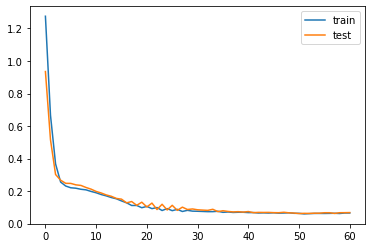

72/72 [==============================] - 1s 10ms/step - loss: 0.0434


In [46]:
# plot history for loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

scores = model.evaluate(test_X, test_y, verbose=1)


In [127]:
# Now compare to Linear Regression model

# 30-day prediction

tsLinRegr = ts[:, 0]
no_steps, no_series = tsLinRegr.shape , 1 

no_hist_days = 30
# list future days to predict
pred_days = np.arange(1, 31, 3) 
print(pred_days)
# what is the furtherest day of prediction
last_pred_day = max(pred_days) 
# how many days are predicted
num_pred_days = len(pred_days)                    


# don't predict for all time-series
list_cols_dropped = [*range(no_hist_days*no_series, (no_hist_days+last_pred_day)*no_series, 1)] 
# predict for exchange rate on the days of pred_days
keep_cols = [(last_pred_day+1-element) * (-no_series) for element in pred_days]   
print(keep_cols)
delete_multiple_elements( list_cols_dropped, keep_cols )
#print('we need to drop the columns: ', list_cols_dropped)

    
    
# ensure all data is float
tsLinRegr = tsLinRegr.astype('float32')
tsLinRegr = tsLinRegr.reshape(-1, 1)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(tsLinRegr)
# frame as supervised learning. The input numbers are history-days and forecast-days
reframed = series_to_supervised(scaled, no_hist_days, last_pred_day)
# drop columns we don't want to predict, i.e. future steps for all time-series except for exchange rate
reframed.drop(reframed.columns[list_cols_dropped], axis=1, inplace=True)
print(reframed.head())    
    
    
values = reframed.values
    
test = values[n_train_days+n_val_days:, :]

# split into input and outputs
test_X, test_y = test[:, :-num_pred_days], test[:, -num_pred_days:]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], no_hist_days, no_series))
print( test_X.shape, test_y.shape)
print(test_X)
print(test_y)   
    

N = test_X.shape[0]
      
learn_window = np.arange(30)
predict_window = np.arange(0, 30, 3)


no_hist_days = 30
pred_days = np.arange(1, 31, 3) 
print(pred_days)
# what is the furtherest day of prediction
last_pred_day






        
stream = []
for i in range(N-60):
            
    ## ==================================================
    Lcap, Pcap = no_hist_days, last_pred_day
            
    detail_window = np.arange(Pcap)

    x_learn = (i+learn_window).reshape(-1, 1)
    y_learn = data_train[i+learn_window]
    x_detail = (i+Lcap+detail_window).reshape(-1, 1)
    y_detail = data_train[i+Lcap+detail_window]

    model = sklearn.linear_model.LinearRegression()
    model.fit(x_learn, y_learn)

    x_predict = (i+Lcap+predict_window).reshape(-1, 1)
    y_predict = model.predict(x_predict)

    mse = np.mean(np.square(y_predict - y_detail[predict_window]))
    scale_factor = 1/scaler.scale_[0] # bring back to original scale
    mse *= scale_factor
    ## ==================================================
        
    stream.append(mse)
            
print("%.3e" % np.mean(stream))

[ 1  4  7 10 13 16 19 22 25 28]
[-28, -25, -22, -19, -16, -13, -10, -7, -4, -1]
    var1(t-30)  var1(t-29)  var1(t-28)  var1(t-27)  var1(t-26)  var1(t-25)  \
30    0.629794    0.629794    0.598117    0.590582    0.589726    0.588870   
31    0.629794    0.598117    0.590582    0.589726    0.588870    0.593664   
32    0.598117    0.590582    0.589726    0.588870    0.593664    0.593664   
33    0.590582    0.589726    0.588870    0.593664    0.593664    0.593664   
34    0.589726    0.588870    0.593664    0.593664    0.593664    0.599486   

    var1(t-24)  var1(t-23)  var1(t-22)  var1(t-21)  ...   var1(t)  var1(t+3)  \
30    0.593664    0.593664    0.593664    0.599486  ...  0.696062   0.659075   
31    0.593664    0.593664    0.599486    0.586815  ...  0.690925   0.672260   
32    0.593664    0.599486    0.586815    0.590240  ...  0.683562   0.672260   
33    0.599486    0.586815    0.590240    0.599658  ...  0.659075   0.672260   
34    0.586815    0.590240    0.599658    0.620719 

NameError: name 'data_train' is not defined

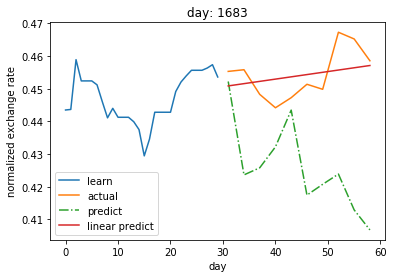

MSE of RNN: 1.101e-03
MSE of Linear Regression: 4.209e-05


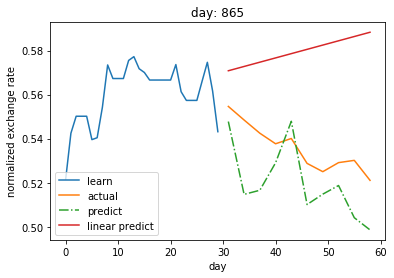

MSE of RNN: 3.739e-04
MSE of Linear Regression: 2.163e-03


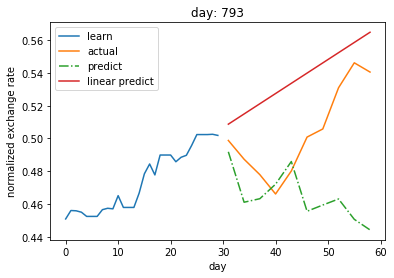

MSE of RNN: 2.830e-03
MSE of Linear Regression: 1.374e-03


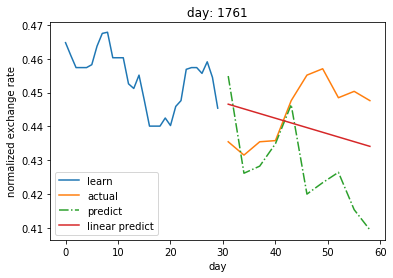

MSE of RNN: 5.996e-04
MSE of Linear Regression: 1.598e-04


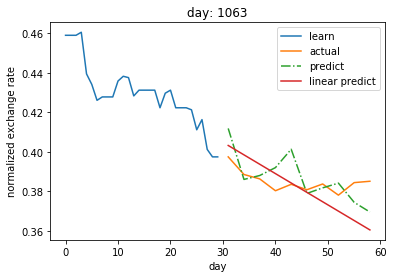

MSE of RNN: 1.052e-04
MSE of Linear Regression: 1.383e-04


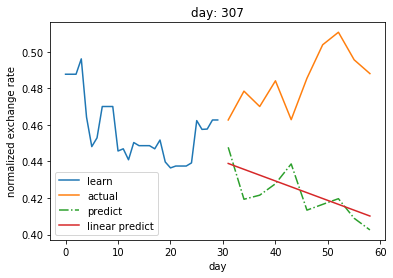

MSE of RNN: 4.568e-03
MSE of Linear Regression: 4.076e-03


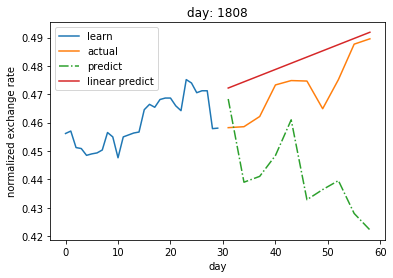

MSE of RNN: 1.368e-03
MSE of Linear Regression: 1.370e-04


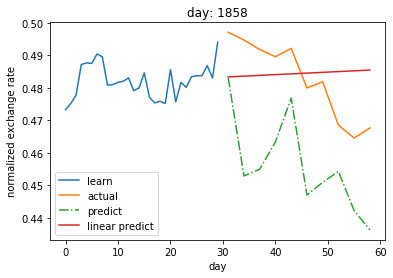

MSE of RNN: 7.940e-04
MSE of Linear Regression: 1.513e-04


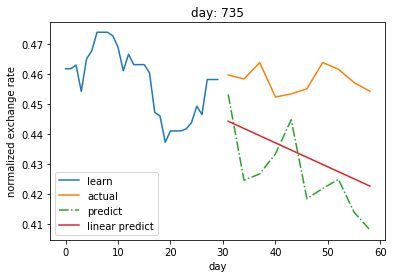

MSE of RNN: 1.144e-03
MSE of Linear Regression: 6.554e-04


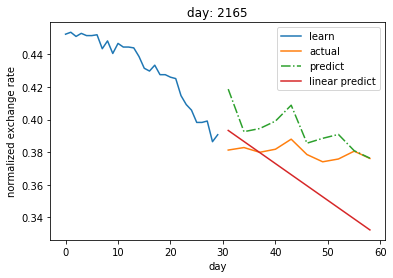

MSE of RNN: 2.918e-04
MSE of Linear Regression: 6.076e-04


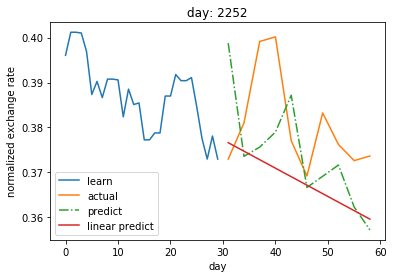

MSE of RNN: 2.432e-04
MSE of Linear Regression: 2.481e-04


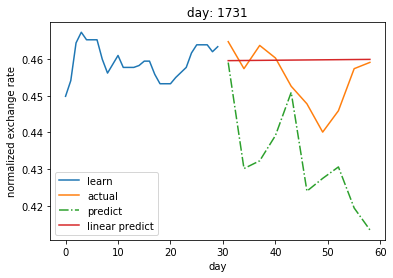

MSE of RNN: 6.703e-04
MSE of Linear Regression: 8.321e-05


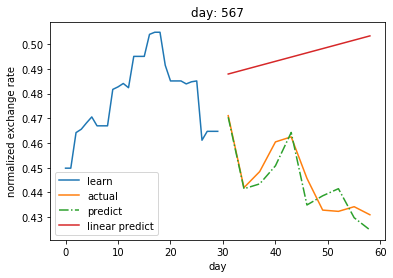

MSE of RNN: 4.127e-05
MSE of Linear Regression: 2.766e-03


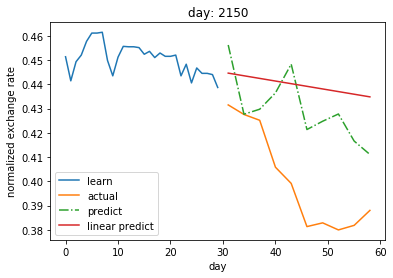

MSE of RNN: 1.137e-03
MSE of Linear Regression: 1.844e-03


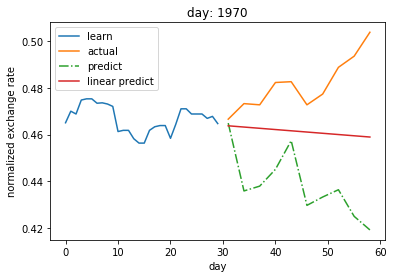

MSE of RNN: 2.318e-03
MSE of Linear Regression: 5.510e-04


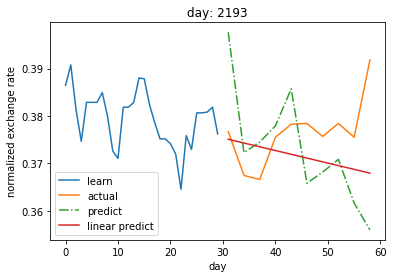

MSE of RNN: 2.333e-04
MSE of Linear Regression: 9.196e-05


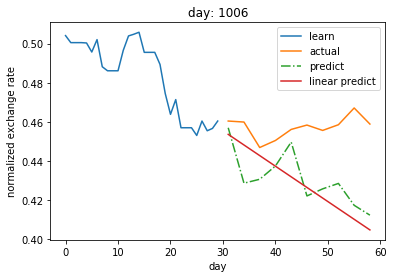

MSE of RNN: 9.206e-04
MSE of Linear Regression: 1.117e-03


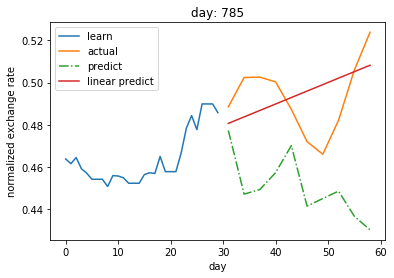

MSE of RNN: 2.412e-03
MSE of Linear Regression: 3.094e-04


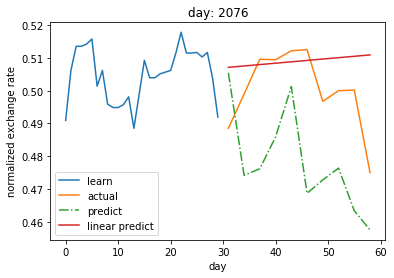

MSE of RNN: 7.392e-04
MSE of Linear Regression: 2.107e-04


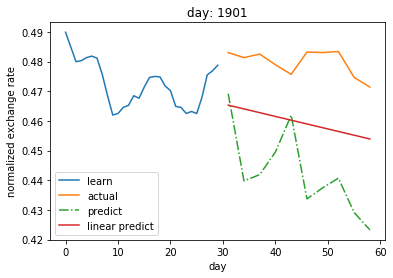

MSE of RNN: 1.537e-03
MSE of Linear Regression: 4.187e-04


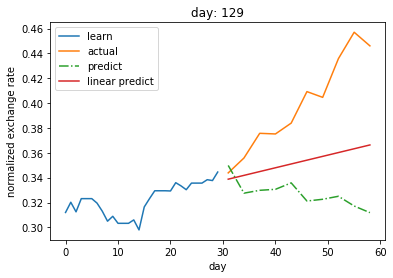

MSE of RNN: 7.156e-03
MSE of Linear Regression: 2.915e-03


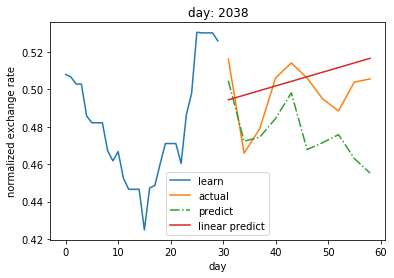

MSE of RNN: 7.304e-04
MSE of Linear Regression: 2.941e-04


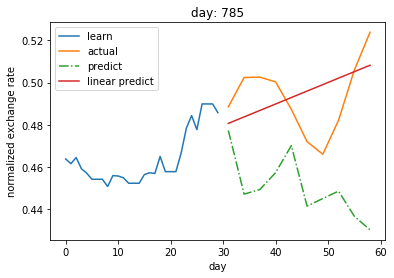

MSE of RNN: 2.412e-03
MSE of Linear Regression: 3.094e-04


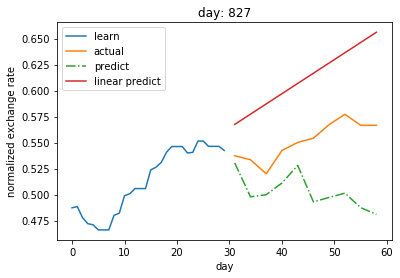

MSE of RNN: 3.116e-03
MSE of Linear Regression: 3.877e-03


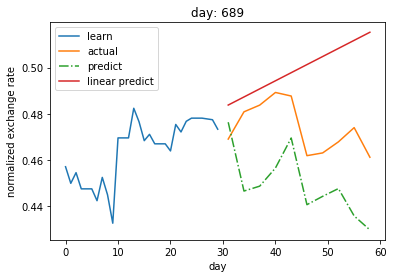

MSE of RNN: 7.544e-04
MSE of Linear Regression: 9.750e-04


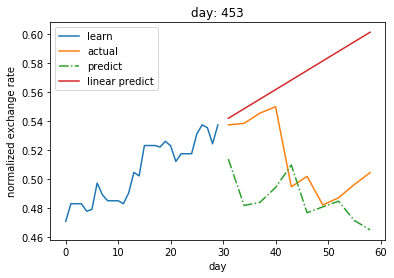

MSE of RNN: 1.364e-03
MSE of Linear Regression: 5.006e-03


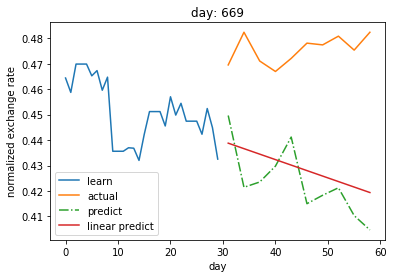

MSE of RNN: 2.997e-03
MSE of Linear Regression: 2.261e-03


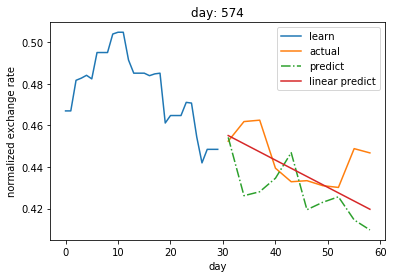

MSE of RNN: 5.507e-04
MSE of Linear Regression: 1.793e-04


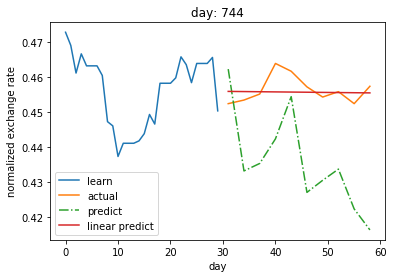

MSE of RNN: 5.956e-04
MSE of Linear Regression: 1.372e-05


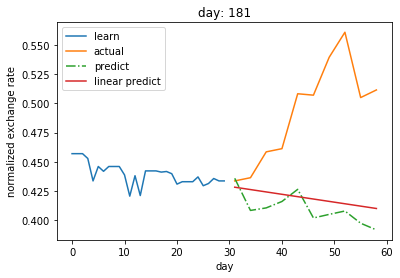

MSE of RNN: 9.001e-03
MSE of Linear Regression: 7.396e-03


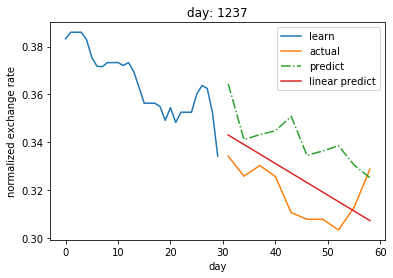

MSE of RNN: 6.382e-04
MSE of Linear Regression: 1.546e-04


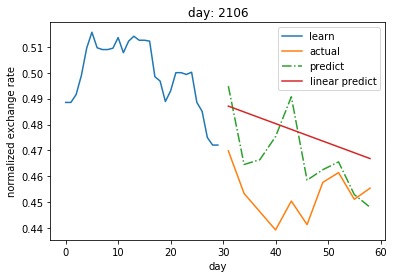

MSE of RNN: 4.450e-04
MSE of Linear Regression: 7.026e-04


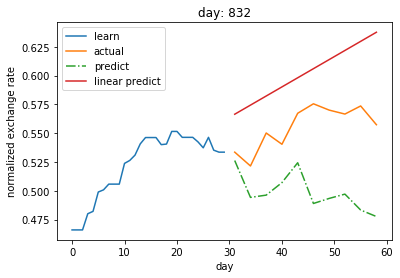

MSE of RNN: 3.932e-03
MSE of Linear Regression: 2.380e-03


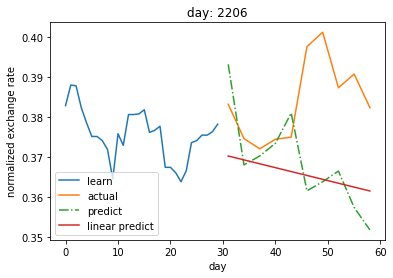

MSE of RNN: 5.346e-04
MSE of Linear Regression: 4.514e-04


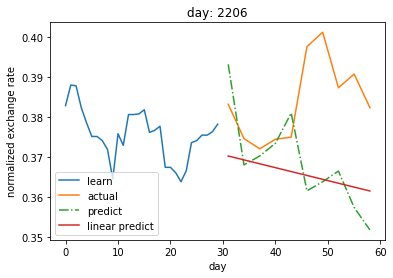

MSE of RNN: 5.346e-04
MSE of Linear Regression: 4.514e-04


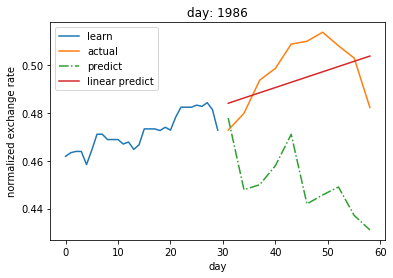

MSE of RNN: 2.571e-03
MSE of Linear Regression: 1.553e-04


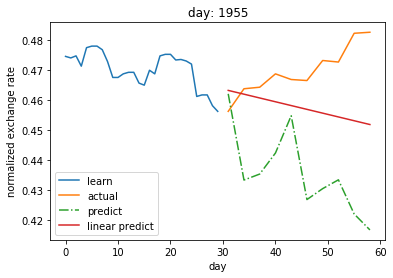

MSE of RNN: 1.555e-03
MSE of Linear Regression: 2.758e-04


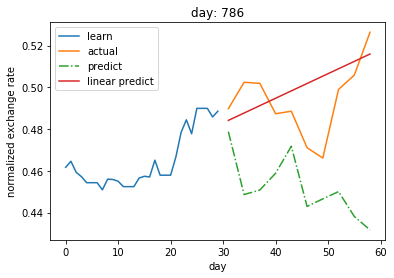

MSE of RNN: 2.385e-03
MSE of Linear Regression: 3.247e-04


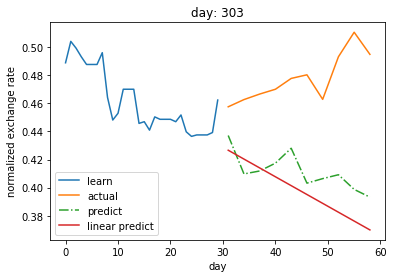

MSE of RNN: 5.051e-03
MSE of Linear Regression: 7.393e-03


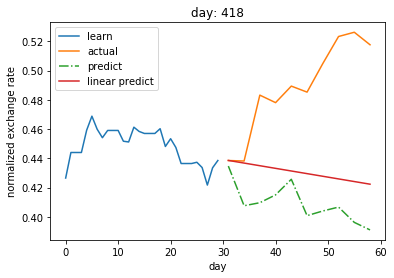

MSE of RNN: 7.816e-03
MSE of Linear Regression: 4.572e-03


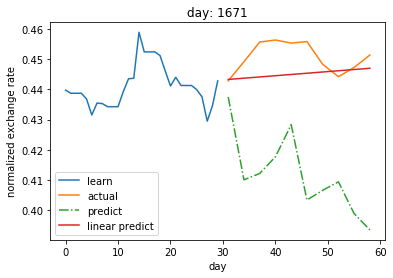

MSE of RNN: 1.709e-03
MSE of Linear Regression: 5.517e-05


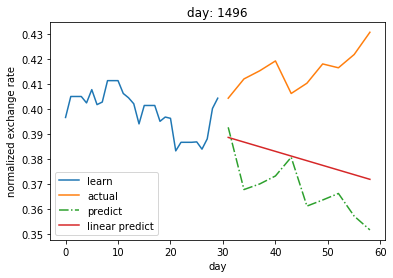

MSE of RNN: 2.522e-03
MSE of Linear Regression: 1.378e-03


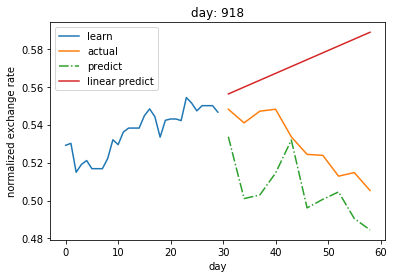

MSE of RNN: 7.308e-04
MSE of Linear Regression: 2.445e-03


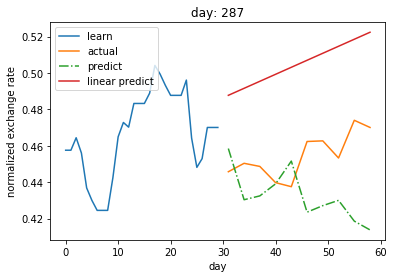

MSE of RNN: 1.057e-03
MSE of Linear Regression: 2.628e-03


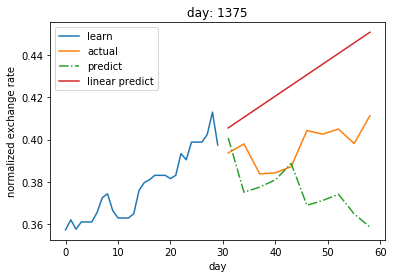

MSE of RNN: 7.723e-04
MSE of Linear Regression: 1.104e-03


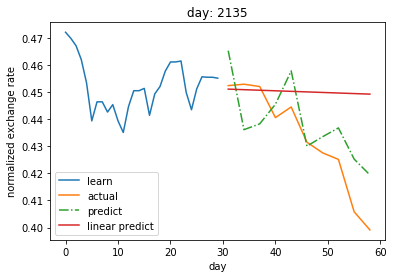

MSE of RNN: 1.801e-04
MSE of Linear Regression: 5.996e-04


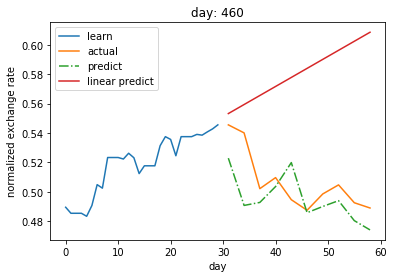

MSE of RNN: 4.289e-04
MSE of Linear Regression: 6.793e-03


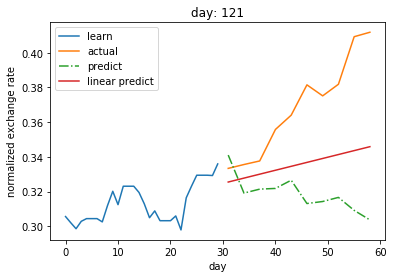

MSE of RNN: 3.747e-03
MSE of Linear Regression: 1.519e-03


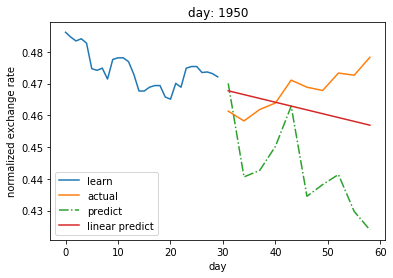

MSE of RNN: 8.869e-04
MSE of Linear Regression: 1.156e-04


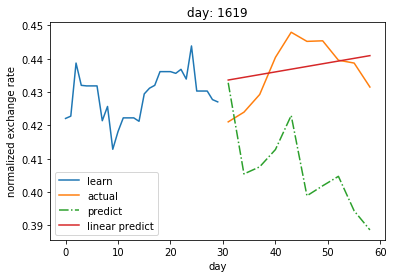

MSE of RNN: 1.139e-03
MSE of Linear Regression: 6.390e-05


In [47]:
import sklearn.linear_model

np.random.seed(0)
for i in np.random.randint(30, test_X.shape[0]-31, size=50):
    watch_window = test_X[i,:,:]
    #print(watch_window.shape )
    watch_window = watch_window.reshape( (1,no_hist_days,-1) )
    watch_window_plot = test_X[i,:,0]
    actual = test_y[i,:]
    prediction = model.predict(watch_window)
    prediction = prediction.reshape( (10,) )
    
    lin_mod = sklearn.linear_model.LinearRegression()
    lin_mod.fit(np.arange(no_hist_days).reshape(-1, 1), watch_window_plot)
    lin_pred = lin_mod.predict((no_hist_days+pred_days).reshape(-1, 1) )
    
    pyplot.plot(np.arange(no_hist_days), watch_window_plot, label='learn')
    pyplot.plot(no_hist_days+pred_days , actual, label='actual')    #np.arange(last_pred_day)
    pyplot.plot(no_hist_days+pred_days, prediction, '-.', label='predict')
    pyplot.plot(no_hist_days+pred_days, lin_pred, label='linear predict')
    pyplot.title('day: %d' % i)
    pyplot.ylabel('normalized exchange rate')
    pyplot.xlabel('day')
    pyplot.legend()
    pyplot.show()

    mse = np.mean(np.square(prediction - actual))
    mse_lr = np.mean(np.square(lin_pred - actual))
#     scale_factor = 1/scaler.scale_[0]   ## bring back to original scale
#     mse *= scale_factor
    
    print("MSE of RNN: %.3e" % mse)
    print("MSE of Linear Regression: %.3e" % mse_lr)



    
    